# Edge feed patch antenna benchmark

The patch antenna is a ubiquitous antenna type used in modern wireless communication systems. In this notebook, we demonstrate how to simulate a patch antenna using Flexcompute's RF solver and benchmark its performance against a commercial FEM-based full-wave solver. We compare key metrics, such as return loss and gain profile.

<center><img src="./img/edge_feed_patch_antenna_render.png" width=480 /></center>

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.smatrix as sm
import tidy3d.web as web
import xarray as xr
from tidy3d.plugins.dispersion import FastDispersionFitter
from tidy3d.plugins.microwave import LobeMeasurer

td.config.logging_level = "ERROR"

## Setup

### General Parameters

We will conduct a broadband sweep from 10 MHz to 40 GHz to scan for the resonance(s) of this patch antenna. The target operating frequency of the antenna is around 35.3 GHz.

In [2]:
# Frequency range
f_min, f_max = (0.01e9, 40e9)

# Target operating frequency
f_target = 35.3e9

# Frequency sample points (including f_target)
freqs = np.sort(np.append(np.linspace(f_min, f_max, 301), f_target))

### Material and Structures

Both the substrate and conductor materials are assumed to be lossy and have constant loss parameters over the frequency range. 

In [3]:
# Lossy substrate (rel. epsilon = 2.2, loss tangent = 0.0009)
med_sub = FastDispersionFitter.constant_loss_tangent_model(
    2.2, 0.0009, (f_min, f_max), tolerance_rms=2e-4
)

# Lossy metal (conductivity = 58e6 S/m)
med_metal = td.LossyMetalMedium(conductivity=58, frequency_range=(f_min, f_max))

Output()

The geometry is constructed below. Note that the default length unit is microns. We introduce a scaling factor `mm` for convenience.

In [4]:
# Geometry parameters
mm = 1000
t = 0.02 * mm  # Metal thickness
h = 0.254 * mm  # Substrate thickness

In [5]:
# Create substrate and ground planes
str_sub = td.Structure(
    geometry=td.Box(center=(0, 0, -h / 2), size=(6 * mm, 10 * mm, h)), medium=med_sub
)
str_gnd = td.Structure(
    geometry=td.Box(center=(0, 0, -h - t / 2), size=(6 * mm, 10 * mm, t)), medium=med_metal
)

# Create feed structure
str_feed1 = td.Structure(
    geometry=td.Box.from_bounds(rmin=(2 * mm, -0.31 * mm, 0), rmax=(3 * mm, 0.31 * mm, t)),
    medium=med_metal,
)
str_feed2 = td.Structure(
    geometry=td.Box.from_bounds(rmin=(0.5 * mm, -0.05 * mm, 0), rmax=(2 * mm, 0.05 * mm, t)),
    medium=med_metal,
)

# Create antenna structure
ant_vertices = (
    np.array(
        [
            [-1.3, -2.1],
            [-0.3, -2.1],
            [-0.3, -1.1],
            [0.5, -1.1],
            [0.5, 0.6],
            [-0.19, 0.6],
            [-0.19, -0.62],
            [-1.4, -0.62],
            [-1.4, 0.6],
            [-2.1, 0.6],
            [-2.1, -1.1],
            [-1.3, -1.1],
        ]
    )
    * mm
)
str_ant = td.Structure(
    geometry=td.PolySlab(axis=2, slab_bounds=[0, t], vertices=ant_vertices), medium=med_metal
)

# Full structure list
str_list_full = [str_sub, str_gnd, str_feed1, str_feed2, str_ant]

### Grid and Boundary

We apply the perfectly matched layer (PML) on all external boundaries. As is standard practice for radiation problems, we also include an air buffer region around the antenna. Typically, the thickness of this padding is wavelength/2 on each side. This is so that the PML does not intrude on and distort the near-field. 

In [6]:
# Define simulation size with lambda/2 padding
padding = td.C_0 / f_target / 2
sim_LX = 6 * mm + 2 * padding
sim_LY = 10 * mm + 2 * padding
sim_LZ = 2 * t + h + 2 * padding

In [7]:
# Define PML boundary on all sides
bspec = td.BoundarySpec.all_sides(td.PML())

The grid size in the overall simulation is typically determined by the target wavelength. Thus, in the overall grid specification, we set the maximum grid step size to be wavelength/20. 

That said, it is also important to refine the grid near the metallic structures, as they are responsible for the resonant behavior of the antenna. The `LayerRefinementSpec` serves this purpose. We define a function that creates `LayerRefinementSpec` objects in the top layer (feed structure and antenna) and bottom layer (ground plane) respectively. 

Within each layer, the grid is refined in the normal direction (z) as well as around any metal corners. These are controlled by the `min_steps_along_axis` and `corner_refinement` parameters respectively. 

In [8]:
# Define layer refinement on metallic structures
def create_layer_refinement(structure_list):
    """Create pre-defined layer refinement spec for input structure list"""
    return td.LayerRefinementSpec.from_structures(
        structures=structure_list,
        min_steps_along_axis=2,
        corner_refinement=td.GridRefinement(dl=t / 2, num_cells=2),
    )


lr1 = create_layer_refinement([str_gnd])
lr2 = create_layer_refinement([str_feed1, str_feed2, str_ant])

In [9]:
# Define grid specification
gspec = td.GridSpec.auto(
    wavelength=td.C_0 / f_target,
    min_steps_per_wvl=20,
    layer_refinement_specs=[lr1, lr2],
)

### Excitation

The antenna is fed using a microstrip line with an estimated impedance of 56 ohms using an impedance calculator. We excite the microstrip line with a lumped port of the corresponding impedance, connected to the end of the feed structure.

In [10]:
# Define lumped port excitation
LP1 = sm.LumpedPort(
    center=(3 * mm, 0, -h / 2), size=(0, 0.62 * mm, h), voltage_axis=2, impedance=56, name="LP1"
)

### Monitors

We define two field monitors to visualize the near-field profile at the target resonance frequency. 

In [11]:
# Define near field monitors
mon1 = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[f_target], name="xz plane"
)
mon2 = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[f_target], name="xy plane"
)

Far-field radiation data is calculated by the `DirectivityMonitor`. We first specify the elevation and azimuthal angular sweep points, followed by the `DirectivityMonitor` that encloses the whole antenna structure. 

In [12]:
# Define elevation and azimuthal angular observation points
# Theta is the elevation angle and defined relative to global +z axis
theta = np.linspace(0, np.pi, 91)
# Phi is the azimuthal angle and defined relative to global +x axis
phi = np.linspace(-np.pi, np.pi, 181)

# The DirectivityMonitor calculates the radiation pattern using a near-to-far-field transformation
mon_radiation = td.DirectivityMonitor(
    center=(0, 0, 0),
    size=(
        0.9 * sim_LX,
        0.9 * sim_LY,
        0.9 * sim_LZ,
    ),  # The monitor should enclose the whole structure of interest
    freqs=[f_target],
    name="radiation",
    phi=phi,
    theta=theta,
    far_field_approx=False,  # Set to False for more accurate computation for slightly higher cost
)

### Simulation and TerminalComponentModeler

The `Simulation` object contains all the information relevant to the simulation defined thus far. 

For broadband simulations that stretch into lower frequencies (<1 GHz), it can be helpful to reduce the `shutoff` threshold to allow for the low frequency content of the time signal to die out. This ensures converged S-parameter values. Be sure to also increase the `run_time` to allow sufficient simulation time to reach the threshold.

In [13]:
# Define simulation object
sim = td.Simulation(
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_full,
    grid_spec=gspec,
    boundary_spec=bspec,
    monitors=[mon1, mon2],
    run_time=3e-9,
    shutoff=1e-7,
    plot_length_units="mm",
)

The `TerminalComponentModeler` (TCM) is a wrapper object that automatically runs a port sweep on the simulation using user-defined `ports` and constructs the full S-parameter matrix. In this case there is only 1 port. The `radiation_monitors` setting is where we include the previously defined `DirectivityMonitor`. 

In [14]:
# Define TerminalComponentModeler
tcm = sm.TerminalComponentModeler(
    simulation=sim,
    ports=[LP1],
    radiation_monitors=[mon_radiation],
    freqs=freqs,
    remove_dc_component=False,  # Set to False when sim is broadband and includes low frequencies (<1 GHz)
)

### Plotting

Before running, we should plot the simulation and check the grid. 

In [15]:
# Visualize the simulation in 3D (ports and radiation monitor not shown)
sim.plot_3d()

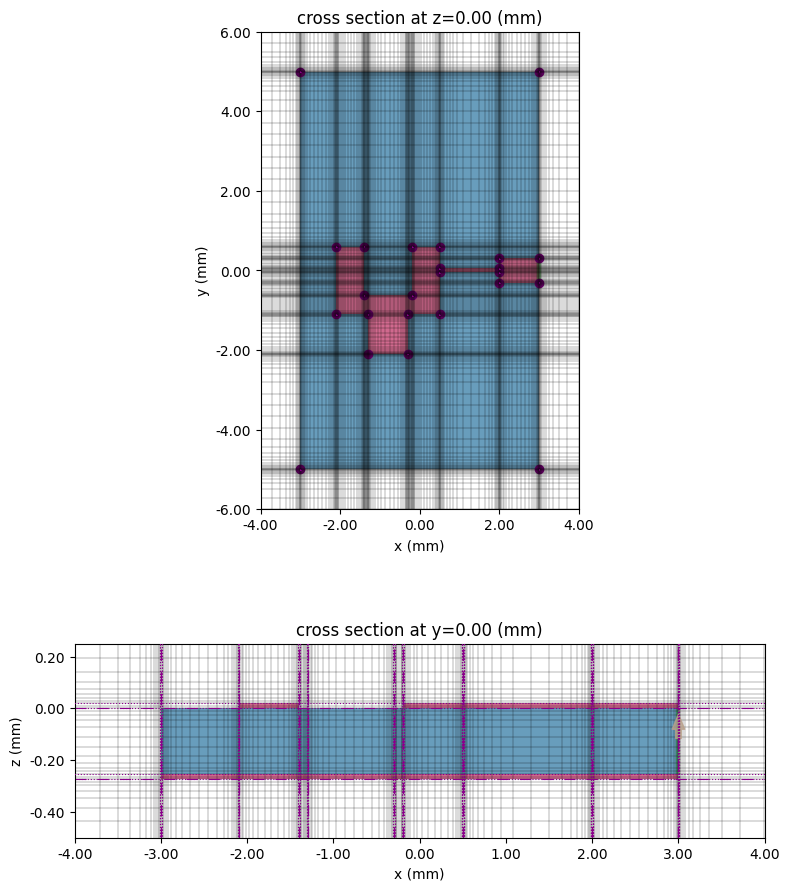

In [16]:
# Plot structures and grid at z=0 and y=0 cross sections
fig, ax = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)
tcm.plot_sim(z=0, ax=ax[0], monitor_alpha=0)
sim.plot_grid(z=0, ax=ax[0])
ax[0].set_xlim(-4 * mm, 4 * mm)
ax[0].set_ylim(-6 * mm, 6 * mm)
tcm.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
sim.plot_grid(y=0, ax=ax[1])
ax[1].set_xlim(-4 * mm, 4 * mm)
ax[1].set_ylim(-0.5 * mm, 0.25 * mm)
ax[1].set_aspect(3)
plt.show()

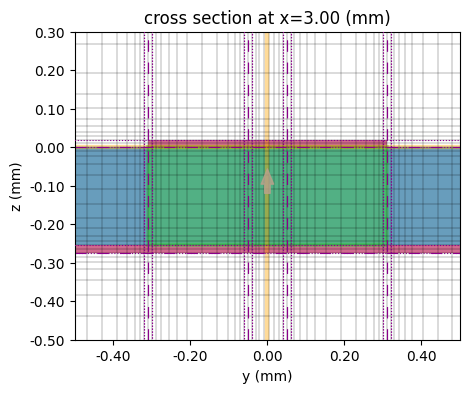

In [17]:
# Plot lumped port
fig, ax = plt.subplots(figsize=(6, 4))
tcm.plot_sim(x=3 * mm, ax=ax)
sim.plot_grid(x=3 * mm, ax=ax)
ax.set_xlim(-0.5 * mm, 0.5 * mm)
ax.set_ylim(-0.5 * mm, 0.3 * mm)
plt.show()

### Running the Simulation

Use `tidy3d.web.upload()` to upload the TCM job and get a cost estimation. 

In [18]:
task_id = web.upload(tcm, task_name="edge_feed_tcm")

09:44:20 EDT Created task 'edge_feed_tcm' with resource_id                      
             'sid-58c60bb8-f594-4c09-9a99-267e4062ed64' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=809040;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=651064;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\taskId]8;;\]8;id=809040;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\=]8;;\]8;id=134351;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\pa]8;;\]8;id=809040;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\-62703178-c9b3-41b3-8b]8;;\
             ]8;id=809040;https://tidy3d.simulation.cloud/rf?taskId=pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9\3c-3cf96847d5d9']8;;\.

             Task folder: ]8;id=4517;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

09:44:21 EDT Child simulation subtasks are being uploaded to                    
             - LP1: 'rf-8ef75327-4f41-4e5d-b0ac-7edccbebd2ce'

09:44:22 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 0.428. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

The sequence of commands below starts the job, monitors progress, and downloads the results once it is finished. 

In [19]:
# Run simulation
web.start(task_id)
web.monitor(task_id)
tcm_data = web.load(task_id)

09:44:23 EDT Component modeler batch validation has been successful.

             Subtasks status - edge_feed_tcm                                    
             Group ID: 'pa-62703178-c9b3-41b3-8b3c-3cf96847d5d9'

Output()

09:46:08 EDT Modeler has finished running successfully.

09:46:09 EDT Billed FlexCredit cost: 0.240. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:46:10 EDT loading component modeler data from ./cm_data.hdf5

The downloaded data is a `TerminalComponentModelerData` object. Use the `smatrix()` command to obtain the S-matrix. 

In [20]:
# Calculate s-matrix
smat = tcm_data.smatrix()

## Results

### S-parameter

Below, we extract the simulated S11 and compare with the benchmark data. We observe good agreement. 

In [21]:
# Extract S11 from smatrix
S11 = np.conjugate(smat.data.isel(port_in=0, port_out=0))

In [22]:
# Import benchmark data
freqs_fem, S11dB_fem = np.genfromtxt(
    "./misc/edge_feed_patch_fem.csv", delimiter=",", skip_header=1, unpack=True
)

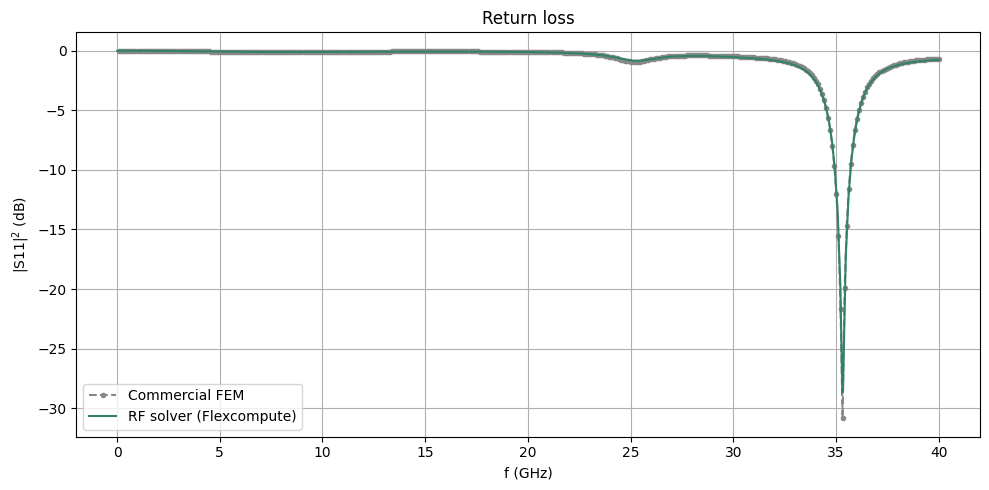

In [23]:
# Plot S11 in dB
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs_fem, S11dB_fem, "--.", color="#888888", label="Commercial FEM")
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), color="#328362", label="RF solver (Flexcompute)")
ax.legend()
ax.grid()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("|S11|$^2$ (dB)")
ax.set_title("Return loss")
plt.show()

### Field profiles

To access the monitor data, we need to first load the `SimulationData` instance associated with the desired port excitation. This can be accessed using the appropriate key (the port name) on the dictionary stored in the `data` attribute of the TCM data. 

In [24]:
# Access the simulation data for port 1 excitation
sim_data = tcm_data.data["LP1"]

We plot the field profiles at `f=f_target` below. 

/Users/yuanshenli/Documents/GitHub/tidy3d/tidy3d-dev/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


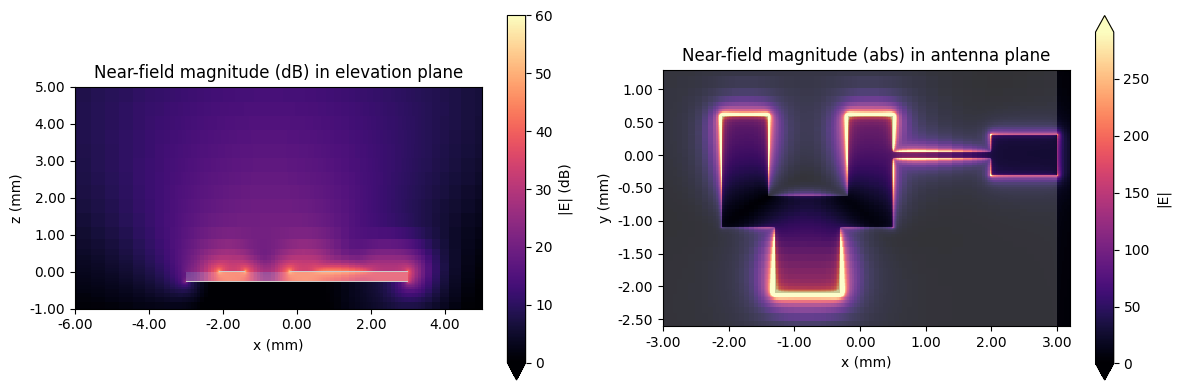

In [25]:
# Visualize near-field profiles
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
sim_data.plot_field(
    "xz plane", field_name="E", val="abs", scale="dB", f=f_target, ax=ax[0], vmax=60, vmin=0
)
ax[0].set_title("Near-field magnitude (dB) in elevation plane")
ax[0].set_xlim(-6 * mm, 5 * mm)
ax[0].set_ylim(-1 * mm, 5 * mm)
sim_data.plot_field("xy plane", field_name="E", val="abs", scale="lin", f=f_target, ax=ax[1])
ax[1].set_title("Near-field magnitude (abs) in antenna plane")
ax[1].set_xlim(-3 * mm, 3.2 * mm)
ax[1].set_ylim(-2.6 * mm, 1.3 * mm)
plt.show()

### Antenna Gain

The `get_antenna_metrics_data()` method of the TCM data object calculates common antenna metrics provided a radiation monitor is defined. Below, we extract the gain data and compare it with benchmark data.  

In [26]:
# Get antenna metrics from simulation data
antenna_metrics = tcm_data.get_antenna_metrics_data()

# Extract gain data
gain = antenna_metrics.gain

In [27]:
# Import and organize benchmark data
imp = np.genfromtxt("./misc/edge_feed_patch_fem_gain.csv", delimiter=",", skip_header=1)
phi_fem = np.unique(imp[:, 1]) / 180 * np.pi
theta_fem = np.unique(imp[:, 2]) / 180 * np.pi
gain_fem = xr.DataArray(
    np.reshape(imp[:, -1], (-1, 91)), coords={"phi": phi_fem, "theta": theta_fem}
)

Below is a convenience function that collects the gain data for forward and backward directions (`phi` and `phi-180` degrees) into a single array. We need to do this because the elevation angle `theta` ranges between (0, 180) degrees whereas the azimuthal angle `phi` ranges between (-180, 180) degrees. 

In [28]:
def get_full_elevation_plane_data(data, phi_forward, phi_backward):
    """Get full elevation plane data for given phi (azimuth) forward and backward angle"""
    # Assemble full theta (elevation angle) coordinate
    thetas = data.theta
    thetas_full = np.unique(np.append(-thetas, thetas))

    # Assemble data
    data_forward = data.sel(phi=phi_forward, method="nearest").squeeze()
    data_backward = data.sel(phi=phi_backward, method="nearest").squeeze()
    data_full = np.append(data_backward[:0:-1], data_forward)

    return thetas_full, data_full

The gain data for the elevation planes `phi=0` degrees and `phi=90` degrees are collected below. 

In [29]:
# Get gain in the elevation plane for phi = 0 and 90 degrees
theta_elev, gain_elev = get_full_elevation_plane_data(gain, phi_forward=0, phi_backward=-np.pi)
_, gain_elev_90 = get_full_elevation_plane_data(
    gain, phi_forward=np.pi / 2, phi_backward=-np.pi / 2
)

# Get same data for benchmark dataset
_, gain_elev_fem = get_full_elevation_plane_data(gain_fem, phi_forward=0, phi_backward=-np.pi)
_, gain_elev_fem_90 = get_full_elevation_plane_data(
    gain_fem, phi_forward=np.pi / 2, phi_backward=-np.pi / 2
)

We plot the gain comparison below. 

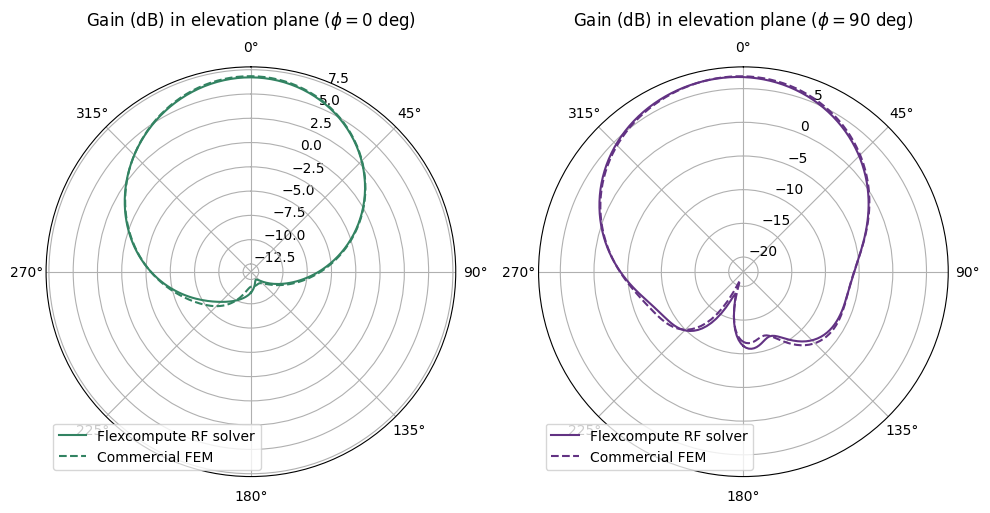

In [30]:
# Gain comparison plot
fig, ax = plt.subplots(1, 2, figsize=(10, 8), tight_layout=True, subplot_kw={"projection": "polar"})

# Plot gain for phi =0
ax[0].plot(theta_elev, 10 * np.log10(gain_elev), color="#328362", label="Flexcompute RF solver")
ax[0].plot(theta_elev, 10 * np.log10(gain_elev_fem), "--", color="#328362", label="Commercial FEM")
ax[0].set_title("Gain (dB) in elevation plane ($\\phi=0$ deg)", pad=30)

# Plot gain for phi = 90deg
ax[1].plot(theta_elev, 10 * np.log10(gain_elev_90), color="#623283", label="Flexcompute RF solver")
ax[1].plot(
    theta_elev, 10 * np.log10(gain_elev_fem_90), "--", color="#623283", label="Commercial FEM"
)
ax[1].set_title("Gain (dB) in elevation plane ($\\phi=90$ deg)", pad=30)

for axis in ax:
    axis.set_theta_direction(-1)
    axis.set_theta_offset(np.pi / 2.0)
    axis.legend()

plt.show()

The `LobeMeasurer` is a Tidy3D plugin tool that automatically calculates lobe measurements based on a radiation profile. 

In [31]:
# Calculate radiation lobe properties
lobes = LobeMeasurer(angle=theta_elev, radiation_pattern=gain_elev, apply_cyclic_extension=False)
lobes_fem = LobeMeasurer(
    angle=theta_elev, radiation_pattern=gain_elev_fem, apply_cyclic_extension=False
)

The properties of the main lobe are reported below. Angle units are radians. In addition to the `main_lobe` property, users can also view `lobe_measures` for a summary table of all detected lobes, `side_lobes` for side lobe properties, and `sidelobe_level`.

In [32]:
# Report main lobe properties
lobes.main_lobe

direction                                                   -0.0
magnitude                                               4.693362
beamwidth                                               1.470175
beamwidth magnitude                                     2.346681
beamwidth bounds       (-0.7828170969748398, 0.6873574528133486)
FNBW                                                         NaN
FNBW bounds                                           (nan, nan)
Name: 0, dtype: object

The main lobe is compared between the RF solver and the benchmark. 

In [33]:
print(
    f"RF solver: The main lobe is at theta = {lobes.main_lobe.direction / np.pi * 180:.0f} degrees, magnitude = {lobes.main_lobe.magnitude:.1f}, and beamwidth = {lobes.main_lobe.beamwidth / np.pi * 180:.0f} degrees"
)

RF solver: The main lobe is at theta = -0 degrees, magnitude = 4.7, and beamwidth = 84 degrees


In [34]:
print(
    f"FEM benchmark: The main lobe is at theta = {lobes_fem.main_lobe.direction / np.pi * 180:.0f} degrees, magnitude = {lobes_fem.main_lobe.magnitude:.1f}, and beamwidth = {lobes_fem.main_lobe.beamwidth / np.pi * 180:.0f} degrees"
)

FEM benchmark: The main lobe is at theta = -0 degrees, magnitude = 4.8, and beamwidth = 83 degrees


The `LobeMeasurer.plot()` method automatically adds markers to indicate main lobe direction and -3 dB beamwidth. This is demonstrated below. 

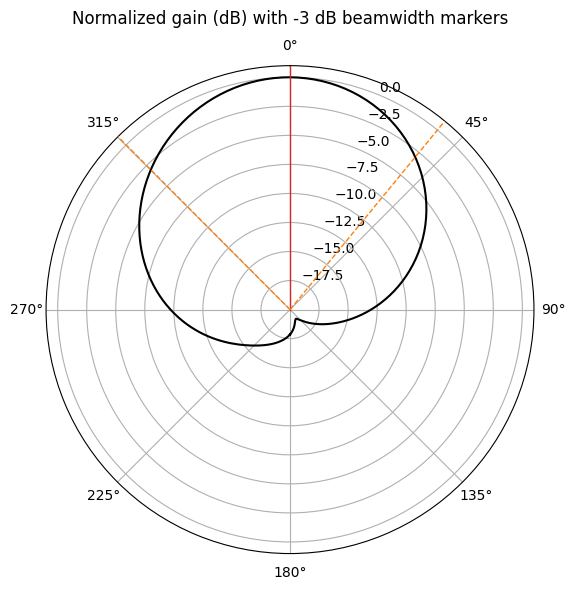

In [35]:
# Gain comparison plot
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True, subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)

# Plot gain for phi =0
ax.plot(theta_elev, 10 * np.log10(gain_elev / np.max(gain_elev)), color="black")
lobes.plot(lobe_index=0, ax=ax)
ax.set_ylim(-20, 1)
ax.set_title("Normalized gain (dB) with -3 dB beamwidth markers", pad=30)
plt.show()

### 3D Radiation Pattern

In this section, we demonstrate how to plot the radiation pattern in 3D. The `ipympl` library enables interactive plots so that we can rotate the 3D plot with the mouse cursor. (This function is only available in a Jupyter notebook and does not work on the browser.)

In [36]:
# Activate interactive plotting for 3D radiation pattern
# Requires ipympl library to be installed (comment line below if requirement not met)
%matplotlib widget

/Users/yuanshenli/Documents/GitHub/tidy3d/tidy3d-dev/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/yuanshenli/Documents/GitHub/tidy3d/tidy3d-dev/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


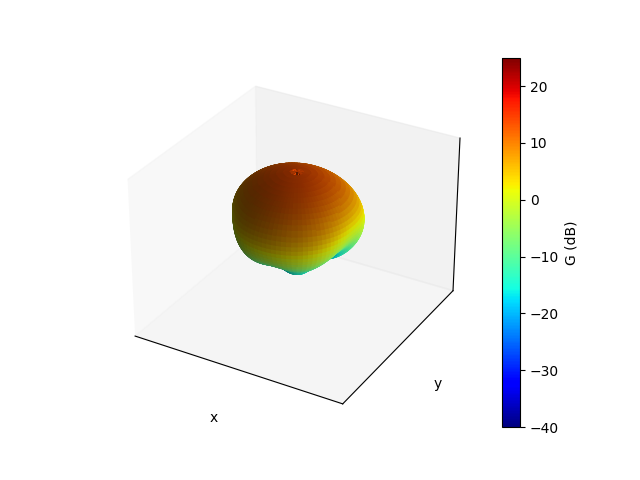

In [37]:
# Create figure and axes
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(1, 1, 1, projection="3d")
limits = 1.0
ax_3d.set_xlim(-limits, limits)
ax_3d.set_ylim(-limits, limits)
ax_3d.set_zlim(-limits, limits)
ax_3d.set_xticks([])
ax_3d.set_yticks([])
ax_3d.set_zticks([])
ax_3d.set_xlabel("x")
ax_3d.set_ylabel("y")
ax_3d.set_zlabel("z")

# Rescale gain according to max and min dB values
dB_min, dB_max = (-40, 25)
G = 20 * np.log10(np.abs(gain.squeeze()))
G_scaled = np.clip((G - dB_min) / (dB_max - dB_min), a_min=0, a_max=1)

# Create 3D dataset according to scaled gain
phi_s, theta_s = np.meshgrid(phi, theta)
X = G_scaled * np.cos(phi_s) * np.sin(theta_s)
Y = G_scaled * np.sin(phi_s) * np.sin(theta_s)
Z = G_scaled * np.cos(theta_s)

# Select color map
color_map = plt.cm.jet

# Plot surface
surf = ax_3d.plot_surface(
    X,
    Y,
    Z,
    cstride=2,
    rstride=2,
    facecolors=color_map(G_scaled),
)

# Plot color bar
cbar = fig_3d.colorbar(
    plt.cm.ScalarMappable(norm=colors.Normalize(vmax=dB_max, vmin=dB_min), cmap=color_map),
    ax=ax_3d,
    label="G (dB)",
)
plt.show()

In [38]:
# Close 3D figure and deactivate interactive plotting
plt.close(fig_3d)
%matplotlib inline

## Lowering Simulation Cost

For benchmark purposes, we used a relatively fine simulation grid. Users might wish to make the grid coarser in order to save on computation costs, particularly if they are still in the design iteration process. In this section, we demonstrate that using a coarser grid can save significantly on cost with a relatively minor compromise to accuracy. 

### Reducing Grid Resolution

The main changes are that we reduced `min_steps_along_axis` to `1` and increased the size of `dl` in the `corner_refinement` setting. 

In [39]:
def create_layer_refinement_coarse(structure_list):
    """Create pre-defined layer refinement spec from input structure list"""
    return td.LayerRefinementSpec.from_structures(
        structures=structure_list,
        min_steps_along_axis=1,
        corner_refinement=td.GridRefinement(dl=2 * t, num_cells=2),
    )


lr3 = create_layer_refinement_coarse([str_gnd])
lr4 = create_layer_refinement_coarse([str_feed1, str_feed2, str_ant])

# Define grid spec
gspec_coarse = td.GridSpec.auto(
    wavelength=td.C_0 / f_target,
    min_steps_per_wvl=20,
    layer_refinement_specs=[lr3, lr4],
)

In [40]:
# Copy new sim and TCM from previous
sim_coarse = sim.updated_copy(grid_spec=gspec_coarse)
tcm_coarse = tcm.updated_copy(simulation=sim_coarse)

We run the simulation below. 

In [41]:
tcm_coarse_data = web.run(tcm_coarse, task_name="tcm_coarse")
smat_coarse = tcm_coarse_data.smatrix()

09:46:12 EDT Created task 'tcm_coarse' with resource_id                         
             'sid-447b8ec6-a6f4-4932-aeac-6197bf8fdac1' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=164756;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=487605;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\taskId]8;;\]8;id=164756;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\=]8;;\]8;id=324663;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\pa]8;;\]8;id=164756;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\-5d45d156-13e8-4ea8-96]8;;\
             ]8;id=164756;https://tidy3d.simulation.cloud/rf?taskId=pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb\a9-c3c4b30e99bb']8;;\.

             Task folder: ]8;id=825179;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

09:46:13 EDT Child simulation subtasks are being uploaded to                    
             - LP1: 'rf-132becf1-5f78-49dc-b9b7-7cd788f3c91a'

09:46:14 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 0.057. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

09:46:15 EDT Component modeler batch validation has been successful.

             Subtasks status - tcm_coarse                                       
             Group ID: 'pa-5d45d156-13e8-4ea8-96a9-c3c4b30e99bb'

Output()

09:47:22 EDT Modeler has finished running successfully.

             Billed FlexCredit cost: 0.057. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:47:24 EDT loading component modeler data from ./cm_data.hdf5

### Comparing Performance

The S-parameter and antenna gain profile are compared below. We observe a relatively minor accuracy reduction for the cheaper simulation, making it suitable for rapid iteration during the initial stages of a component design process.

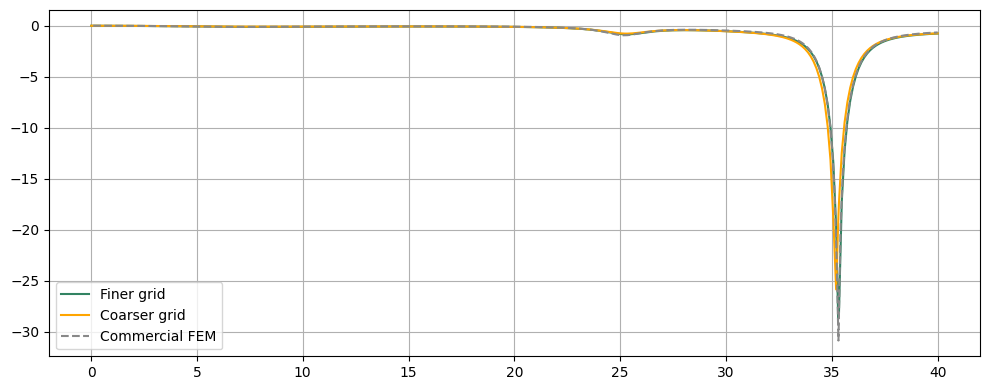

In [42]:
# Compare S-parameter between finer and coarser grid simulations
S11_coarse = np.conjugate(smat_coarse.data.isel(port_in=0, port_out=0))

fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), color="#328362", label="Finer grid")
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11_coarse)), color="orange", label="Coarser grid")
ax.plot(freqs_fem, S11dB_fem, "--", color="#888888", label="Commercial FEM")
ax.legend()
ax.grid()
plt.show()

In [43]:
# Compare antenna gain between finer and coarser grid simulations
antenna_metrics_coarse = tcm_coarse_data.get_antenna_metrics_data()
gain_coarse = antenna_metrics_coarse.gain

In [44]:
# Get gain in the elevation plane for phi = 0 and 90 degrees
_, gain_elev_coarse = get_full_elevation_plane_data(gain_coarse, phi_forward=0, phi_backward=-np.pi)
_, gain_elev_coarse_90 = get_full_elevation_plane_data(
    gain_coarse, phi_forward=np.pi / 2, phi_backward=-np.pi / 2
)

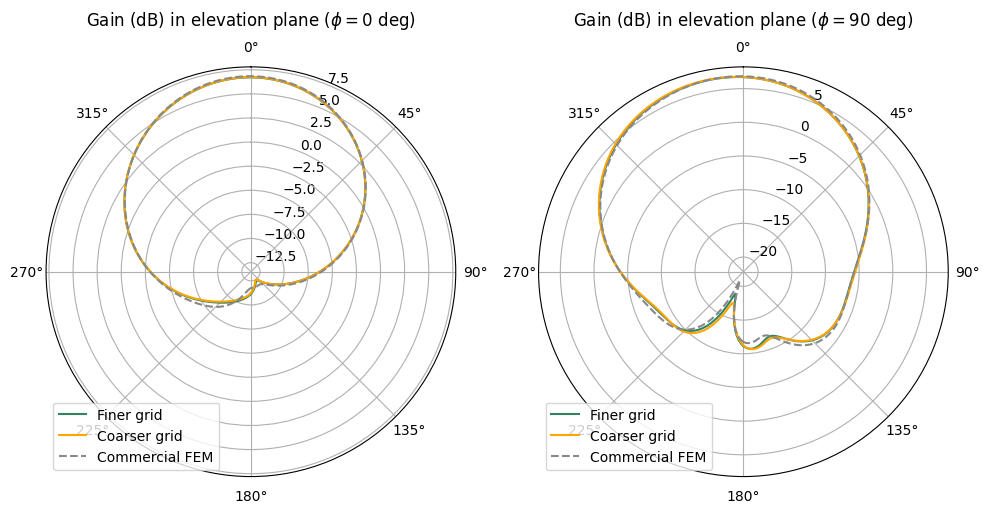

In [45]:
# Gain comparison plot
fig, ax = plt.subplots(1, 2, figsize=(10, 8), tight_layout=True, subplot_kw={"projection": "polar"})

# Plot gain for phi =0
ax[0].plot(theta_elev, 10 * np.log10(gain_elev), color="#328362", label="Finer grid")
ax[0].plot(theta_elev, 10 * np.log10(gain_elev_coarse), color="orange", label="Coarser grid")
ax[0].plot(theta_elev, 10 * np.log10(gain_elev_fem), "--", color="#888888", label="Commercial FEM")
ax[0].set_title("Gain (dB) in elevation plane ($\\phi=0$ deg)", pad=30)

# Plot gain for phi = 90deg
ax[1].plot(theta_elev, 10 * np.log10(gain_elev_90), color="#328362", label="Finer grid")
ax[1].plot(theta_elev, 10 * np.log10(gain_elev_coarse_90), color="orange", label="Coarser grid")
ax[1].plot(
    theta_elev, 10 * np.log10(gain_elev_fem_90), "--", color="#888888", label="Commercial FEM"
)
ax[1].set_title("Gain (dB) in elevation plane ($\\phi=90$ deg)", pad=30)

for axis in ax:
    axis.set_theta_direction(-1)
    axis.set_theta_offset(np.pi / 2.0)
    axis.legend()

plt.show()

## Reference

[1] Khan, J., Ullah, S., Ali, U., Tahir, F. A., Peter, I., & Matekovits, L. (2022). Design of a Millimeter-Wave MIMO Antenna Array for 5G Communication Terminals. Sensors, 22(7), 2768.